<h1>Rolling Regression and Forecasts.</h1>
<p>
    <a href="https://www.statsmodels.org/stable/examples/notebooks/generated/rolling_ls.html">Statsmodel Documentation</a><br />
    <a href="https://plotly.com/python/">Plotly Documentation</a><br />
    <a href="https://pandas.pydata.org/docs/user_guide/index.html#user-guide">Pandas Documentation</a>
</p>

In [1]:
import numpy as np
import pandas as pd

# statsmodel libraries
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
%matplotlib inline

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

# For Notebooks
init_notebook_mode(connected=True)

# For offline use
cf.go_offline()

<h2>Getting the Data Ready</h2>

<h3> Macroeconomic Data </h3>

In [2]:
# exchange rate data
er = pd.read_csv('./data/er.csv', index_col='DATE', parse_dates=True)
er = er.iloc[:197]

# cpi (prices) data
cpi = pd.read_csv('./data/cpi.csv', index_col=1, parse_dates=True)
cpi_can = cpi[cpi['LOCATION'] == 'CAN']
cpi_usa = cpi[cpi['LOCATION'] == 'USA']

<h3> Google Trends Data </h3>

In [3]:
# for the search term "prices"
prices_usa = pd.read_csv('./data/prices-us.csv', index_col=0, parse_dates=True).iloc[:197]
prices_can = pd.read_csv('./data/prices_can.csv', index_col=0, parse_dates=True).iloc[:197]

<h3> Compiling the data together </h3>

In [4]:
df = pd.DataFrame()
df['actual_exr'] = er.values.ravel()
df['can/usa_cpi'] = (cpi_can['Value'].values)/cpi_usa['Value'].values
df['can/usa_priceTerm'] = (prices_can.values)/prices_usa.values
df.index = cpi_can.index
df.describe()

,actual_exr,can/usa_cpi,can/usa_priceTerm
count,197.000000,197.000000,197.000000
mean,1.168193,1.001758,0.764415
std,0.132377,0.013413,0.092204
min,0.955315,0.985504,0.569231
25%,1.037623,0.993093,0.690909
50%,1.161481,0.997811,0.759259
75%,1.300441,1.005090,0.826923
max,1.420811,1.044527,1.093750


<h2> Decomposing into trend and seasonality </h2>

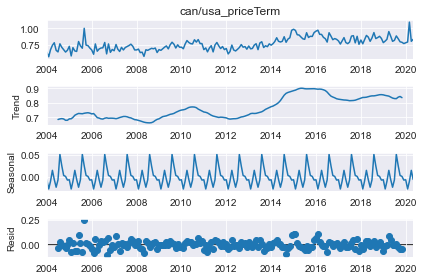

In [5]:
# for google trends indicator
result = seasonal_decompose(df['can/usa_priceTerm'], model='additive')
result.plot()
plt.show()

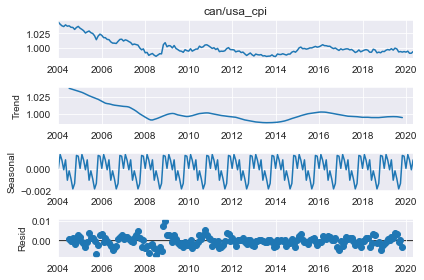

In [6]:
# for macroeconomic fundamental
result = seasonal_decompose(df['can/usa_cpi'], model='additive')
result.plot()
plt.show()

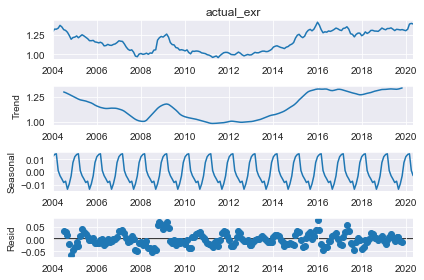

In [7]:
# for our dependent variable
result = seasonal_decompose(df['actual_exr'], model='additive')
result.plot()
plt.show()

<h2> The Analysis </h2>

In [8]:
window = 12 # window length to consider for training the model

<h3> Rolling Window Regression using official macroeconomic data </h3>

In [9]:
y_predicted = list()
for i in range(len(df)-window-1):
    y = df.iloc[i:i+window]['actual_exr']
    X = sm.add_constant(df.iloc[i:i+window]['can/usa_cpi'])
    model = sm.OLS(y,X)
    results = model.fit()
    y_predicted.append(np.array([1,df.iloc[i+window+1]['can/usa_cpi']]).dot(np.array(results.params)))

<h3> Rolling Window Regression using google trends data as proxy</h3>

In [10]:
y_predicted_gt = list()
for i in range(len(df)-window-1):
    y = df.iloc[i:i+window]['actual_exr']
    X = sm.add_constant(df.iloc[i:i+window]['can/usa_priceTerm'])
    model = sm.OLS(y,X)
    results = model.fit()
    y_predicted_gt.append(np.array([1,df.iloc[i+window+1]['can/usa_priceTerm']]).dot(np.array(results.params)))

<h2> Predictions </h2>

In [11]:
df.loc[window+1:,'macro_prediction'] = y_predicted
df.loc[window+1:,'google_trends_prediction'] = y_predicted_gt

<ipython-input-11-b1cf76502724>:1: FutureWarning:

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.

<ipython-input-11-b1cf76502724>:2: FutureWarning:

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.



In [12]:
df[['actual_exr','macro_prediction','google_trends_prediction']].iplot()

<h2> Some graphical analysis </h2>

In [13]:
px.scatter(df, x='can/usa_priceTerm', y='actual_exr', trendline='ols')

<h2> Error Analysis </h2>

In [14]:
df['MSE_macro'] = (df['actual_exr'] - df['macro_prediction'])**2
df['MSE_gt'] = (df['actual_exr'] - df['google_trends_prediction'])**2

In [15]:
error = list()

In [16]:
# structural model MSE
error.append(df['MSE_macro'].describe()['mean'])
error.append(df['MSE_gt'].describe()['mean'])

In [17]:
pd.DataFrame(error,['PPP Model','Google Trends Model'],columns=['Mean Square Prediction Error'])

,Mean Square Prediction Error
PPP Model,0.003147
Google Trends Model,0.004552
